#### _Essential setup: [Menu] Kernel > Change Kernel > Python 3_
_(If you restart the Kernel at any point, repeat this step)_

# Ingestion - load Wikipedia 'page view' logs for Nov 13th

Wikipedia keeps hourly log files counting how many times each page on wikipedia was viewed in that hour.

Firstly - ingest all logs Nov 13th 2015 (the day of the Paris attacks):
* Ingests 24 compressed log files (each approximately 450Mb decompressed) - 226 Million log entries in total
* Cleans data for querying - type conversion, field injection, etc.
* Calculates the total number of page views for the day, across all languages
* Filters off pages with negligible view count (e.g. 1 view)

In [27]:
# Create a SparkContext, if one doesn't already exist
import pyspark
if 'sc' not in locals(): sc = pyspark.SparkContext()

# handy function for looking at load times
import time
def print_elapsed(start_time): print ("[elapsed time: %.2f s]" % (time.time() - start_time))
start_time = time.time() # time how long this takes

filenameformat = './pagecounts-20151113-%02d0000.gz'                    # AWS
#filenameformat = '/resources/pagecounts-20151113-%02d0000.gz'           # datascientistworkbench
# filenameformat = 'dbfs:/tmp/pagecounts-20151113-%02d0000.gz'           # databricks

hour_of_first_logfile = 0
hour_of_last_logfile  = 23

# Optimisation: Ignore pages with very low numbers of views per hour, there are millions of them (e.g. pages
# with 1 view), but they add nothing more than a contribution to the overall total page views.
# 50 is a resonable value. In low-resource environments, 100 is OK (minimal effect on the results)
views_threshold = 50
pagename_representing_filtered_page_counts = 'less_than_threshold'

# load in the raw wikipedia logfiles in parallel across the cluster
# Then parse the raw text lines of text and add an hour field into the data (so we can filter on time).
# Must .cache() these RDDs to materialise them. Otherwise, all the RDDs end up with the same hour: 23
rawRDDs = []
rawRDDs = [sc.textFile(filenameformat % (hour)) \
           .map(lambda rawTextLine: (hour, rawTextLine.split(" "))) \
           .map(lambda hour_tokens: ((hour_tokens[0], hour_tokens[1][0], hour_tokens[1][1]), int(hour_tokens[1][2]))) \
           .cache() \
           for hour in range(hour_of_first_logfile, hour_of_last_logfile + 1)]

# Now combine the raw RDDs into one logical one (Spark will still distribute the processing close to the data)
rawRDD = sc.union(rawRDDs)
totalEntries = rawRDD.count() # count the total number of log entries being processed. NB: count here *before* the speed optimisation filter

# print an example raw text line for context
rawLogSample = rawRDD.take(1)
print ("The pre-processed log entry format is [(<hour>, <language>, <page>), <page_views>] e.g. %s" % (rawLogSample))

# Split the pages we're more/less interested in (those with more/less views than our chosen threshold).
# Amalgamate pages we're less interested in (see note above). This preserves the validity of subsequent
# counts, without continually re-processing millions of low-view pages
lessThanThresholdRDD = rawRDD.filter(lambda key_views: key_views[1] < views_threshold) \
    .map(lambda key_views: ((key_views[0][0], key_views[0][1], pagename_representing_filtered_page_counts), key_views[1])) \
    .reduceByKey(lambda x, y: x + y)
moreThanThresholdRDD = rawRDD.filter(lambda key_views: key_views[1] >= views_threshold)

# Add the regular and amalgamated pages back together
logfileEntriesRDD = sc.union([moreThanThresholdRDD, lessThanThresholdRDD])
logfileEntriesRDD.cache()
totalViews = logfileEntriesRDD.map(lambda key_views: key_views[1]).sum() # count the total number of page views represented in the log entries

print_elapsed(start_time)


The pre-processed log entry format is [(<hour>, <language>, <page>), <page_views>] e.g. [((0, 'aa', '367._pne'), 1)]
[elapsed time: 480.56 s]


# Interactive: Count the page views by selected language and time range.
* Filter log entries by language and time period.
* Each page will have multiple view counts (one per hour).
* Compute the total view count for each page across the time period (sum per-page, per-period)


In [28]:
def countPageViewsByLanguageAndTimeRange(rdd, language, minhour, maxhour, printText=False):
    
    # filter off pages belonging to our language (note can have en, en.mobile, etc)
    perLanguageRDD = rdd.filter(lambda key_views: ((key_views[0][1] == language) or (key_views[0][1].startswith(language + '.'))))
    # add up all the counts across different hours and representations of the language
    totalPerLanguage = perLanguageRDD.map(lambda key_views: key_views[1]).sum()
    
    # filter off pages in our time range
    perLanguagePerPeriodRDD = perLanguageRDD.filter(lambda key_views: ((key_views[0][0] >= minhour) and (key_views[0][0] <= maxhour)))
    perLanguagePerPeriodRDD.cache()
    # add up all the counts in this specific time range
    totalPerPeriod = perLanguagePerPeriodRDD.map(lambda key_views: key_views[1]).sum()

    # Sum the hourly page counts by page
    if printText: print ('\nSumming hourly page counts by page...\n\n')
    pageViewsRDD = perLanguagePerPeriodRDD \
        .map(lambda key_views: ((key_views[0][2]), key_views[1])) \
        .reduceByKey(lambda x, y: x + y)
    pageViewsRDD.cache()

    # Print stats, so user can see what's happening
    if printText: print ('#################################################################################')
    print ('Total wikipedia page views on Friday Nov 13th                 : %.1f MILLION (from %.1f million raw log entries)' % (totalViews / 1000000.0, totalEntries / 1000000.0))
    print ('Total page views for language \'%s\'                            : %.1f MILLION ' % (language, (totalPerLanguage / 1000000.0)))
    print ('Number of page views for language \'%s\' (%.2f - %.2f hours)  : %.1f MILLION ' % (language, minhour, maxhour, (totalPerPeriod / 1000000.0)))

    return pageViewsRDD


# Interactive: Find the top 20 pages viewed
* Sort the filtered pages by total view count
* Filter out noise (e.g. analytic script pages)
* Print and plot the top 20 (very simple bar graph)


In [29]:
def top20(rdd, language, minhour, maxhour, printText=False):
    start_time = time.time()
    # Start by filtering down to the appropriate language and time range 
    pageViewsRDD = countPageViewsByLanguageAndTimeRange(rdd, language, minhour, maxhour, printText)

    # Sort the pages by count, so we can identify the top 20
    # (not as inefficient as it looks - Spark will optimise it)
    pageViewsSortedRDD = pageViewsRDD.sortBy(lambda key_views: key_views[1], ascending=False)
    pageViewsSortedRDD.cache()

    # Get the top 20 pages
    # Note: There are often a lot of 'pages' in the top 20 that don't have meaning to regular users
    # e.g. analytics scripts, the landing page, etc. So we'll filter some of these off. This is
    # not inteded to be comprehensive, just a quick job to make the Nov 13th results informative
    top20List = pageViewsSortedRDD \
        .filter(lambda page_views: page_views[0] not in ['Main_Page', '', 'index.html', language, pagename_representing_filtered_page_counts]) \
        .filter(lambda page_views: ':' not in page_views[0]) \
        .filter(lambda page_views: '-webkit-linear-gradient' not in page_views[0]) \
        .take(20)
    if printText:
        print ('######################## TOP 20 PAGES BY NUMBER OF VIEWS ########################')
        for line in top20List: print ('\t%s:\t%s' % (line[1], line[0]))
        print ('#################################################################################')

    # Print them in a simple bar chart
    pages = [i[0][0:21] for i in top20List][::-1]
    views = [i[1] for i in top20List][::-1]
    if (not printText):
      %matplotlib inline
      import matplotlib
      import matplotlib.pyplot as plt
      import numpy as np
      plt.rcParams["figure.figsize"] = [8.0, 6]
      y_pos = np.arange(len(top20List))
      with plt.style.context('fivethirtyeight'): plt.barh(y_pos, views, alpha=0.4)
      plt.axes().yaxis.grid(False) # no horizontal lines
      plt.yticks(y_pos + 0.5, pages)
      plt.xlabel('\nPage Views')
      plt.title('Top 20 \'%s\' page views on Wikipedia (Nov 13th %.2f-%.2f UTC)\n' % (language, minhour, maxhour))
      plt.show()

    # Return the top 20
    print_elapsed(start_time)
    return top20List

# The Goal: Interactive analysis of the top 20 pages

Can now do interactive analysis of these log entries. Select a language and a time period to find out what the top 20 pages viewed in that time period were.

We picked Nov 13th as the sad events in Paris can be seen in the results - look at the top 20 'fr' pages in the afternoon (1-6pm). Then look again from 22 to 23 (ie 10-11pm) and you can see the effect of the events in Paris

### French top 20, afternoon (1-6pm)

Total wikipedia page views on Friday Nov 13th                 : 843.6 MILLION (from 225.9 million raw log entries)
Total page views for language 'fr'                            : 36.7 MILLION 
Number of page views for language 'fr' (13.00 - 18.00 hours)  : 11.6 MILLION 


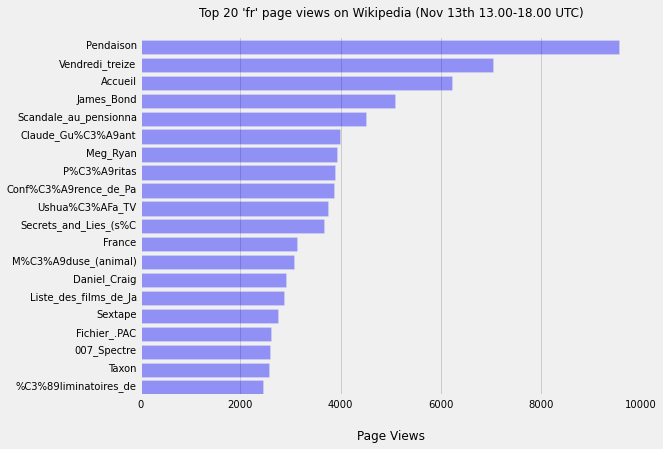

[elapsed time: 2.12 s]


In [71]:

top20List = top20(logfileEntriesRDD, 'fr', 13, 18)


### English top 20, afternoon (1-6pm)

Total wikipedia page views on Friday Nov 13th                 : 843.6 MILLION (from 225.9 million raw log entries)
Total page views for language 'en'                            : 387.7 MILLION 
Number of page views for language 'en' (13.00 - 18.00 hours)  : 103.0 MILLION 


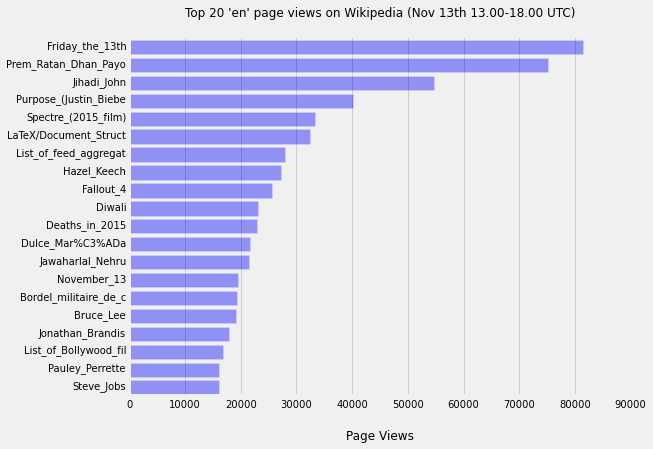

[elapsed time: 2.19 s]


In [72]:

top20List = top20(logfileEntriesRDD, 'en', 13, 18)


# Play with the language and time range here
* Try French top 20, as news of the attack was breaking (21.00 - 22.00)
* Try French top 20, from 22.00 - 23.00
* Try English top 20, for the same period


Total wikipedia page views on Friday Nov 13th                 : 843.6 MILLION (from 225.9 million raw log entries)
Total page views for language 'fr'                            : 36.7 MILLION 
Number of page views for language 'fr' (21.00 - 22.00 hours)  : 4.8 MILLION 


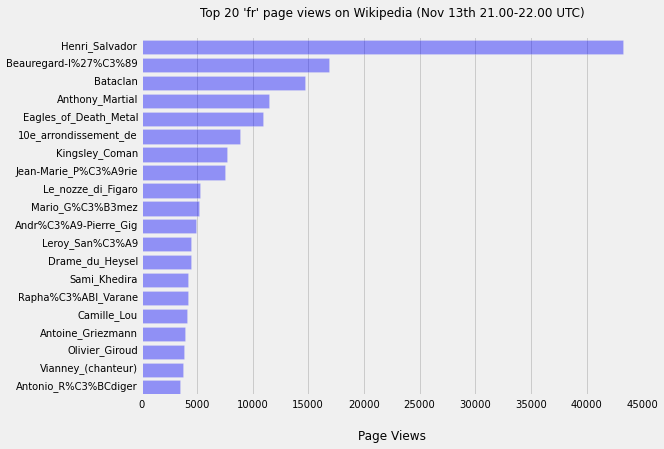

[elapsed time: 2.15 s]


In [73]:

top20List = top20(logfileEntriesRDD, 'fr', 21, 22)
